In [1]:
from sklearn.model_selection import train_test_split
from models.ResNet import ResNet18
import librosa
import numpy as np
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from Utils import read_data,create_dataloader, k_fold_cross_validation, train, test
import matplotlib.pyplot as plt

# Read Data 

In [2]:
sr = 16 * 1000
x,y,min_length = read_data(root='../Data/genres_original', sr=sr)
print("finsh reading data")

finsh reading data


# Conversion, Compression and Normalisation

In [3]:
top_db = 80
for i in range(len(x)):
    signal = x[i][:min_length]
    mel_spect = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=1024) # convert signals to mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max, top_db=top_db) # log compression
    x[i] = mel_spect/-top_db # normalisation
print("finish conversion and compression")

finish conversion and compression


# Split Data

In [4]:
x = np.asarray(x)
x = x.transpose((0,2,1))
x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
y = np.asarray(y)
print(x.shape)

(1000, 1, 936, 128)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y,shuffle=True)
# k-fold cross validation
k = 5
xs_train, ys_train, xs_valid, ys_valid = k_fold_cross_validation(x_train,y_train,k)
print("finish splitting data")

finish splitting data


In [6]:
batch_size = 64
dataloaders_train = []
dataloaders_valid = []
for i in range(k):
    dataloaders_train.append(create_dataloader(xs_train[i], ys_train[i], batch_size=batch_size))
    dataloaders_valid.append(create_dataloader(xs_valid[i], ys_valid[i], batch_size=batch_size))
dataloader_test = create_dataloader(x_test, y_test, batch_size=batch_size)
print("finish creating dataloaders")

finish creating dataloaders


# Model Construction

In [7]:
model = ResNet18(10,pre_filter_size=3,in_channels=1)
model.cuda()
loss_function = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=0.001)
summary(model,[(batch_size,1,x.shape[2],x.shape[3])])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 235, 33]         --
│    └─Conv2d: 2-1                       [64, 64, 469, 65]         640
│    └─BatchNorm2d: 2-2                  [64, 64, 469, 65]         128
│    └─ReLU: 2-3                         [64, 64, 469, 65]         --
│    └─MaxPool2d: 2-4                    [64, 64, 235, 33]         --
├─ResidualBlock: 1-2                     [64, 64, 235, 33]         --
│    └─Conv2d: 2-5                       [64, 64, 235, 33]         36,928
│    └─BatchNorm2d: 2-6                  [64, 64, 235, 33]         128
│    └─ReLU: 2-7                         [64, 64, 235, 33]         --
│    └─Conv2d: 2-8                       [64, 64, 235, 33]         36,928
│    └─BatchNorm2d: 2-9                  [64, 64, 235, 33]         128
│    └─ReLU: 2-10                        [64, 64, 235, 33]         --
├─R

# Train

In [8]:
epoch = 10
history = train(model,loss_function,opt,dataloaders_train,dataloaders_valid,k,epoch=epoch)
print("finish training")

-------epoch  1 -------
fold 1:
train set loss: 2.1882755041122435
train set accuracy: 0.234375
valid set loss: 2.318132209777832
valid set accuracy: 0.08749999850988388
fold 2:
train set loss: 2.0830790996551514
train set accuracy: 0.4046874940395355
valid set loss: 2.4007166385650636
valid set accuracy: 0.03750000149011612
fold 3:
train set loss: 2.0545371532440186
train set accuracy: 0.4906249940395355
valid set loss: 2.2637523651123046
valid set accuracy: 0.26250001788139343
fold 4:
train set loss: 2.033642888069153
train set accuracy: 0.534375011920929
valid set loss: 2.3277678966522215
valid set accuracy: 0.13125000894069672
fold 5:
train set loss: 2.0166523575782778
train set accuracy: 0.5484375357627869
valid set loss: 2.21683554649353
valid set accuracy: 0.13125000894069672
epoch loss: 2.305
epoch accuracy: 0.13
-------epoch  2 -------
fold 1:
train set loss: 2.0069323778152466
train set accuracy: 0.582812488079071
valid set loss: 2.0861892223358156
valid set accuracy: 0.31874

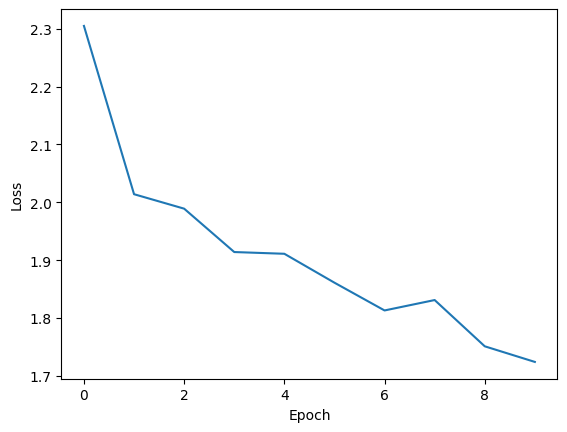

In [9]:
plt.plot(range(epoch),history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

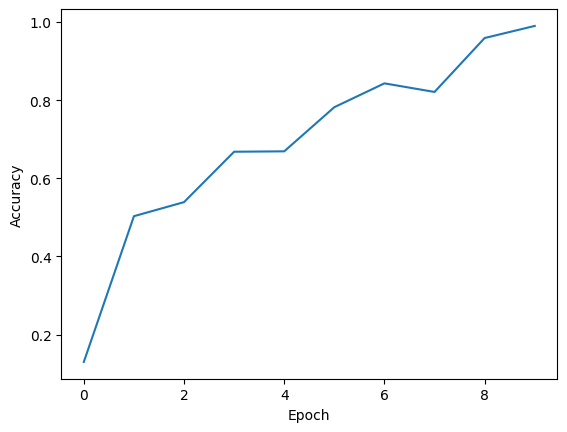

In [10]:
plt.plot(range(epoch),history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test

In [11]:
loss, acc, AUC, f1 = test(model,loss_function,dataloader_test)

test set loss: 1.871
test set accuracy: 0.75
test set AUC: 0.937
test set f1-score: 0.75


(1.871, 0.75, 0.937, 0.75)